In [1]:
from qiskit.algorithms import VQE, NumPyMinimumEigensolver, NumPyEigensolver #Algorithms

#Qiskit odds and ends
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP, L_BFGS_B
from qiskit.opflow import Z2Symmetries, X, Y, Z, I, PauliSumOp, Gradient
from qiskit import IBMQ, BasicAer, Aer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.utils.mitigation import CompleteMeasFitter #Measurement error mitigatioin
from qiskit.tools.visualization import circuit_drawer
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeManila, FakeNairobi

#qiskit_nature
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD, HartreeFock, CHC, VSCF
from qiskit_nature.drivers.second_quantization import PySCFDriver
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.drivers.second_quantization import ElectronicStructureMoleculeDriver, ElectronicStructureDriverType, MethodType
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer , FreezeCoreTransformer
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms import AdaptVQE,VQEUCCFactory, GroundStateEigensolver, QEOM, NumPyEigensolverFactory, ExcitedStatesEigensolver

#Python odds and ends
import matplotlib
import matplotlib.pyplot as plt
import matplotlib
import pylab
import numpy as np
import os
import pyscf
from IPython.display import display, clear_output

from datetime import datetime
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

#IBMQ.load_account()
#provider = IBMQ.get_provider(group='open')
#set Backends
#simulators
backend_stv = Aer.get_backend('aer_simulator_statevector')
#Noisy simulator
backend_aer = Aer.get_backend('aer_simulator')
device_backend=FakeManila()
device = QasmSimulator.from_backend(device_backend)
noise_model = None
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates
#Real Devices
#backend_nair= provider.get_backend('ibm_nairobi')
#backend_manil = provider.get_backend('ibmq_manila')
#backend_qsm_ibm=provider.get_backend('ibmq_qasm_simulator')

sh=1024 #shots

#solvers
npme = NumPyMinimumEigensolver()
npe=NumPyEigensolver()

In [2]:
provider.backends(simulator=False)

[<IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_oslo') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [2]:
def exact_solver(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

In [3]:
optimizer_sim=L_BFGS_B(maxiter=25)
optimizer_dev=SPSA(maxiter=10)

/opt/homebrew/Caskroom/miniforge/base/envs/qiskit-env/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


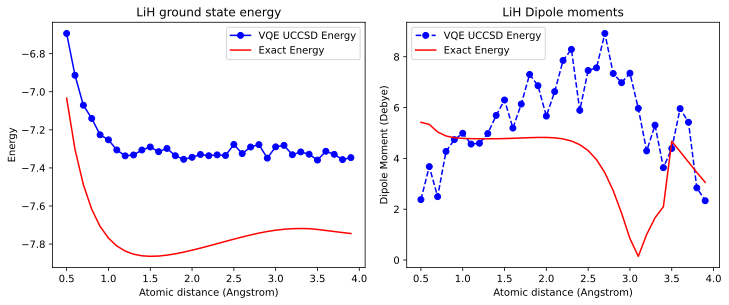

In [46]:
#Adapt VQE Attempt

#Make qubit_operator

def get_qubit_op(dist,mapper):
    
    
    #Define Molecule
    molecule = Molecule(
        # coordinates in Angstrom
        geometry=[
            ["Li", [0.0, 0.0, 0.0]],
            ["H", [dist, 0.0, 0.0]]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )
    
    #Set driver
    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF,
    )

    #Get properties
    properties = driver.run()
    
    #particle_number = problem.grouped_property_transformed.get_property("ParticleNumber")
    num_a_electrons = properties.get_property("ParticleNumber").num_alpha
    num_b_electrons = properties.get_property("ParticleNumber").num_beta
    num_particles=properties.get_property("ParticleNumber").num_particles

    num_spin_orbitals = properties.get_property("ParticleNumber").num_spin_orbitals
    num_spin_orbitals= num_spin_orbitals.item()
    type(np.float64(0).item())

    rep_energy = properties.get_property("ElectronicEnergy").nuclear_repulsion_energy
    en_shift=0
    #en_shift=properties.get_property("ElectronicEnergy").energy_shift
    shift=rep_energy+en_shift
    
    # Check the occupation of the spin orbitals
    PN_property = properties.get_property("ParticleNumber")

    # Define the active space
    # (selected automatically around the HOMO and LUMO, ordered by energy)
    transformer = ActiveSpaceTransformer(
        num_electrons=4, #Electrons in active space
        num_molecular_orbitals=4, #Orbitals in active space
    )
    
    #Define the problem

    problem = ElectronicStructureProblem(driver
                                         , [
                                            transformer 
                                            ,
                                             FreezeCoreTransformer(freeze_core=True
                                                                   # ,remove_orbitals=[3,4,5]
                                                                        )
                                          ]
                                        )
    
    second_q_ops = problem.second_q_ops() # Get 2nd Quant OP. This calls driver.run() internally
    
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles
    
    hamiltonian = second_q_ops[0] #Set Hamiltonian

    #Get Pauli OP
    converter = QubitConverter(mapper)
    qubit_op = converter.convert(hamiltonian)
    
    #Symmetries
    sym=Z2Symmetries.find_Z2_symmetries(qubit_op)
    converter = QubitConverter(mapper
                               #,two_qubit_reduction=True
                               #,z2symmetry_reduction=problem.symmetry_sector_locator(sym,converter)
                              )
    
    #Final OP
    qubit_op = converter.convert(hamiltonian)
    
    
    return qubit_op, num_particles, num_spin_orbitals, converter, problem




distances = np.arange(0.5, 4, 0.1)
exact_energies = []
vqe_energies = []
avqe_energies=[]
exact_dipole=[]
vqe_dipole=[]
avqe_dipole=[]
optimizer = optimizer_dev
mapper=ParityMapper()


seed = 62
algorithm_globals.random_seed = seed
#qi=backend_stv
qi= QuantumInstance(backend_aer, seed_simulator=seed, seed_transpiler=seed, #Noisy Quantum Instance
                          coupling_map=coupling_map,noise_model=noise_model,
                          measurement_error_mitigation_cls=CompleteMeasFitter)

def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)
    
dists=[]
for dist in distances:
    #Qubit_Op
    qubit_op, num_particles, num_spin_orbitals, converter, problem = get_qubit_op(dist,mapper)
    #Initial State
    init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    #classic solver
    result_exact = exact_solver(problem, converter = converter)
    exact_energies.append(result_exact.total_energies)
    exact_dipole.append(np.linalg.norm(result_exact.dipole_moment_in_debye))
    #ansatz
    ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
    
    #VQE
  

    counts = []
    values = []
    params = []
    deviation = []
    dists.append(dist)
    
    # Set initial parameters of the ansatz
    initial_point = [0.01] * ansatz.num_parameters
    
    #VQE Solver
    vqe_factory=VQEUCCFactory(quantum_instance=qi
                         ,optimizer=optimizer
                         ,initial_point=initial_point
                         ,ansatz=ansatz
                         ,callback=callback
                        )
    
    #Normal VQE UCCSD
    solver_vqe=GroundStateEigensolver(converter,vqe_factory)

    vqe_calc=solver_vqe.solve(problem)
    vqe_energies.append(vqe_calc.total_energies)
    vqe_dipole.append(np.linalg.norm(vqe_calc.dipole_moment_in_debye))
    
    #ADAPT VQE
    #solver_avqe = AdaptVQE(converter,vqe_factory,max_iterations=20)

    #avqe_calc=solver_avqe.solve(problem)
   # avqe_energies.append(avqe_calc.total_energies)
    #avqe_dipole.append(np.linalg.norm(avqe_calc.dipole_moment_in_debye))
    
    #clear_output(wait=True)

    
fig, ax=plt.subplots(1,2,figsize=(10,4))
fig.tight_layout()

ax[0].plot(dists, vqe_energies, '-bo',label="VQE UCCSD Energy")
#ax[0].plot(dists, avqe_energies, '--go',label="ADAPT-VQE UCCSD Energy")
ax[0].plot(dists, exact_energies,'r' ,label="Exact Energy")
ax[0].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy',title='LiH ground state energy')
ax[0].legend()

ax[1].plot(dists, vqe_dipole, '--bo',label="VQE UCCSD Energy")
#ax[1].plot(dists, avqe_dipole, '--go',label="ADAPT-VQE UCCSD Energy")
ax[1].plot(dists, exact_dipole,'r' ,label="Exact Energy")
ax[1].set(xlabel='Atomic distance (Angstrom)',ylabel='Dipole Moment (Debye)',title="LiH Dipole moments")
ax[1].legend()


plt.show()

In [32]:
print(init_state)

     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     ├───┤
q_2: ┤ X ├
     └───┘
q_3: ─────
          
q_4: ─────
          
q_5: ─────
          


In [6]:
exact_dipole

[5.659856829264647,
 5.385783286725468,
 5.0630205275056035,
 4.9033778076175984,
 4.835759435614168,
 4.809594695181976,
 4.799659315126055,
 4.7960068755940055,
 4.796037379263689,
 4.799826729277711,
 4.8078264122037195,
 4.8198539511019645,
 4.8347197928247025,
 4.850087589384089,
 4.86234988485553,
 4.866362204562845,
 4.854924189151057,
 4.817917057955796,
 4.741025478598761,
 4.60406353451036,
 4.379266770019025,
 4.030863557664793,
 3.519163477032601,
 2.814460806182388,
 1.9232281252349426,
 0.9133969108392883,
 0.09257294931822888,
 0.9682208443850487,
 1.6361120203980466,
 2.0804130347752583,
 4.671933533141897,
 4.2672458811031415,
 3.8548358159186455,
 3.4472174136269227,
 3.0552541252829033]

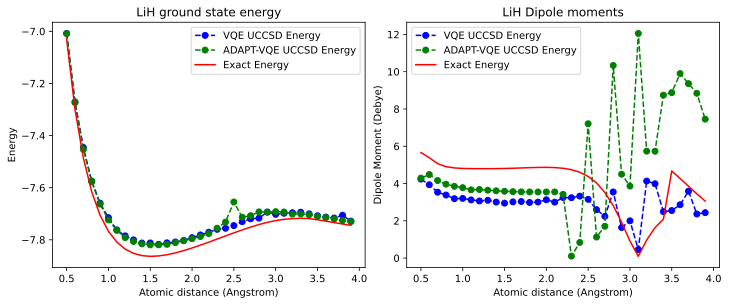

In [7]:
fig, ax=plt.subplots(1,2,figsize=(10,4))
fig.tight_layout()

ax[0].plot(dists, vqe_energies, '--bo',label="VQE UCCSD Energy")
ax[0].plot(dists, avqe_energies, '--go',label="ADAPT-VQE UCCSD Energy")
ax[0].plot(dists, exact_energies,'r' ,label="Exact Energy")
ax[0].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy',title='LiH ground state energy')
ax[0].legend()

ax[1].plot(dists, vqe_dipole, '--bo',label="VQE UCCSD Energy")
ax[1].plot(dists, avqe_dipole, '--go',label="ADAPT-VQE UCCSD Energy")
ax[1].plot(dists, exact_dipole,'r' ,label="Exact Energy")
ax[1].set(xlabel='Atomic distance (Angstrom)',ylabel='Dipole Moment (Debye)',title="LiH Dipole moments")
ax[1].legend()


plt.show()

In [124]:
[0.01]*ansatz.num_parameters

[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

In [10]:
distances = np.arange(0.5, 5, 0.1)
optimizer = L_BFGS_B(maxiter=10)
mapper=ParityMapper()


seed = 62
algorithm_globals.random_seed = seed
#qi=backend_stv
qi= QuantumInstance(backend_aer, seed_simulator=seed, seed_transpiler=seed, #Noisy Quantum Instance
                          coupling_map=coupling_map,noise_model=noise_model,
                          measurement_error_mitigation_cls=CompleteMeasFitter)


#Define Molecule
molecule = Molecule(
        # coordinates in Angstrom
   geometry=[
            ["Li", [0.0, 0.0, 0.0]],
            ["H", [1.6, 0.0, 0.0]]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )
    
#Set driver
driver = ElectronicStructureMoleculeDriver(
                                            molecule=molecule,
                                            basis="sto3g",
                                            driver_type=ElectronicStructureDriverType.PYSCF,
                                            method=MethodType.RKS

                                            )

#Get properties
properties = driver.run()
    
#particle_number = problem.grouped_property_transformed.get_property("ParticleNumber")
num_a_electrons = properties.get_property("ParticleNumber").num_alpha
num_b_electrons = properties.get_property("ParticleNumber").num_beta
num_particles=properties.get_property("ParticleNumber").num_particles

num_spin_orbitals = properties.get_property("ParticleNumber").num_spin_orbitals
num_spin_orbitals= num_spin_orbitals.item()
type(np.float64(0).item())

rep_energy = properties.get_property("ElectronicEnergy").nuclear_repulsion_energy
en_shift=0
#en_shift=properties.get_property("ElectronicEnergy").energy_shift
shift=rep_energy+en_shift
    
# Check the occupation of the spin orbitals
PN_property = properties.get_property("ParticleNumber")

# Define the active space
# (selected automatically around the HOMO and LUMO, ordered by energy)
transformer = ActiveSpaceTransformer(
                                    num_electrons=4, #Electrons in active space
                                    num_molecular_orbitals=6, #Orbitals in active space
                                    )
    
#Define the problem

problem = ElectronicStructureProblem(driver
                                     , [
                                         #transformer
                                        FreezeCoreTransformer(freeze_core=True
                                                              , remove_orbitals=[3,4,5]
                                                              )
                                      ]
                                    )
    
second_q_ops = problem.second_q_ops() # Get 2nd Quant OP. This calls driver.run() internally
    
num_spin_orbitals = problem.num_spin_orbitals
num_particles = problem.num_particles

    
hamiltonian = second_q_ops[0] #Set Hamiltonian

#Get Pauli OP
converter = QubitConverter(mapper)
qubit_op = converter.convert(hamiltonian)
    
#Symmetries
sym=Z2Symmetries.find_Z2_symmetries(qubit_op)
converter = QubitConverter(mapper
                               ,two_qubit_reduction=True
                               #,z2symmetry_reduction='auto'
                              )
    
#Final OP
qubit_op = converter.convert(hamiltonian)

In [135]:
distances = np.arange(0.1, 4, 0.1)
exact_energies = []
vqe_energies = []
avqe_energies=[]
optimizer = COBYLA(maxiter=10)
mapper=ParityMapper()
backend=backend_stv

def exact_solver(problem, converter):
    factory = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, factory)
    result = calc.solve(problem)
    return result

init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
#ansatz
#ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
#classic solver
result_exact = exact_solver(problem, converter = converter)
exact_energies.append(result_exact.total_energies)
#VQE
def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []

# Set initial parameters of the ansatz
# We choose a fixed small displacement 
# So all participants start from similar starting point
initial_point = [0.01] * ansatz.num_parameters

vqe_factory=VQEUCCFactory(quantum_instance=backend
                         ,optimizer=optimizer
                         #,initial_point=initial_point
                         #,ansatz=ansatz
                         ,callback=callback
                        )

solver_vqe=GroundStateEigensolver(converter,vqe_factory)

vqe_calc=solver_vqe.solve(problem)
vqe_energies.append(problem.interpret(vqe_calc).total_energies)


solver_avqe = AdaptVQE(converter
                         ,vqe_factory
                         ,max_iterations=20
                        )
avqe_calc=solver_avqe.solve(problem)
avqe_energies.append(problem.interpret(avqe_calc).total_energies)

'Evaluation: 16, Energy: -0.5756908279025583, Std: 0.0'

In [136]:
print(np.linalg.norm(avqe_calc.dipole_moment_in_debye))

4.853661994859383


In [132]:
qubit_op.num_qubits

4

In [24]:
qubit_op.num_qubits

4

In [ ]:
#Runtime VQE

#Make qubit_operator

def get_qubit_op(dist,mapper):
    
    
    #Define Molecule
    molecule = Molecule(
        # coordinates in Angstrom
        geometry=[
            ["Li", [0.0, 0.0, 0.0]],
            ["H", [dist, 0.0, 0.0]]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )
    
    #Set driver
    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF,
    )
    
    driver_RKS = ElectronicStructureMoleculeDriver(
                                            molecule=molecule,
                                            basis="sto3g",
                                            driver_type=ElectronicStructureDriverType.PYSCF,
                                            method=MethodType.RKS

                                            )

    #Get properties
    properties = driver.run()
    
    # Check the occupation of the spin orbitals
    PN_property = properties.get_property("ParticleNumber")

    # Define the active space
    # (selected automatically around the HOMO and LUMO, ordered by energy)
    transformer = ActiveSpaceTransformer(
        num_electrons=2, #Electrons in active space
        num_molecular_orbitals=3, #Orbitals in active space
    )
    
    #Define the problem

    problem = ElectronicStructureProblem(driver
                                         , [
                                          #  transformer 
                                           # ,
                                             FreezeCoreTransformer(freeze_core=True
                                                                    ,remove_orbitals=[3,4,5]
                                                                         )
                                           ]
                                        )
    problem_RKS= ElectronicStructureProblem(driver_RKS
                                         , [
                                          #  transformer 
                                           # ,
                                             FreezeCoreTransformer(freeze_core=True
                                                                    ,remove_orbitals=[3,4,5]
                                                                         )
                                           ]
                                        )
    
    second_q_ops = problem.second_q_ops() # Get 2nd Quant OP. This calls driver.run() internally
    
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles
    
    hamiltonian = second_q_ops[0] #Set Hamiltonian

    #Get Pauli OP
    converter = QubitConverter(mapper)
    qubit_op = converter.convert(hamiltonian)
    
    #Symmetries
    sym=Z2Symmetries.find_Z2_symmetries(qubit_op)
    converter = QubitConverter(mapper
                               ,two_qubit_reduction=True
                               #,z2symmetry_reduction=problem.symmetry_sector_locator(sym,converter)
                              )
    
    #Final OP
    qubit_op = converter.convert(hamiltonian)
    
    
    return qubit_op, num_particles, num_spin_orbitals, converter, problem


In [ ]:
from qiskit_nature.runtime import VQEClient

distances = np.array([1.0,1.5,2.0,2.5,3.25,4.0])
exact_energies = []
rt_energies = []
exact_dipole=[]
rt_dipole=[]
optimizer = SPSA(maxiter=150)
mapper=ParityMapper()
measurement_error_mitigation = True
store_intermediate=True
    
def rt_callback(nfev, parameters, energy, stddev):
    display("Energy: {}, Std: {}".format(energy, std))
    clear_output(wait=True)
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)
    
dists=[]
intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

for dist in distances:
    #Qubit_Op
    qubit_op, num_particles, num_spin_orbitals, converter, problem = get_qubit_op(dist,mapper)
    #Initial State
    init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    #classic solver
    result_exact = exact_solver(problem, converter = converter)
    exact_energies.append(result_exact.total_energies)
    exact_dipole.append(np.linalg.norm(result_exact.dipole_moment_in_debye))
    #ansatz
    ansatz = EfficientSU2(num_qubits=qubit_op.num_qubits,su2_gates='ry', entanglement='linear', reps=3, initial_state=init_state)
    #initial point
    initial_point = [0.01] * ansatz.num_parameters
    
    
    #VQE
    runtime_vqe = VQEClient(ansatz=ansatz,
                         optimizer=optimizer,
                         initial_point=initial_point,
                         provider=provider,
                         backend=backend_nair,
                         shots=sh,
                         measurement_error_mitigation=measurement_error_mitigation,
                         callback=rt_callback,
                         store_intermediate=store_intermediate)

    rt_result = runtime_vqe.compute_minimum_eigenvalue(qubit_op)
    rt_energies.append(problem.interpret(rt_result).total_energies)
    rt_dipole.append(problem.interpret(rt_result).dipole_moment_in_debye)

    
fig, ax=plt.subplots(1,2,figsize=(10,4))
fig.tight_layout()

ax[0].plot(distances, rt_energies, '-bo',label="Runtime VQE RY Energy")
ax[0].plot(distances, exact_energies,'r' ,label="Exact Energy")
ax[0].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy',title='LiH ground state energy')
ax[0].legend()

ax[1].plot(distances, rt_dipole, '--bo',label="Runtime VQE RY Dipole")
ax[1].plot(distances, exact_dipole,'r' ,label="Exact Energy")
ax[1].set(xlabel='Atomic distance (Angstrom)',ylabel='Dipole Moment (Debye)',title="LiH Dipole moments")
ax[1].legend()


plt.show()

In [ ]:
distances = np.arange(1, 4, 0.1)
dists=[]
exact_energies=[]
exact_dipole=[]
for dist in distances:
    #Qubit_Op
    qubit_op, num_particles, num_spin_orbitals, converter, problem = get_qubit_op(dist,mapper)
    #Initial State
    #init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    #classic solver
    result_exact = exact_solver(problem, converter = converter)
    exact_energies.append(result_exact.total_energies)
    exact_dipole.append(np.linalg.norm(result_exact.dipole_moment_in_debye))
    dists.append(dist)

In [ ]:
distances = np.array([1.0,1.5,2.0,2.5,3.25,4.0])

exact_rt_energies=[]
exact_rt_dipole=[]
for dist in distances:
    #Qubit_Op
    qubit_op, num_particles, num_spin_orbitals, converter, problem = get_qubit_op(dist,mapper)
    #Initial State
    #init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    #classic solver
    result_exact = exact_solver(problem, converter = converter)
    exact_rt_energies.append(result_exact.total_energies)
    exact_rt_dipole.append(np.linalg.norm(result_exact.dipole_moment_in_debye))

In [ ]:
distances = np.array([1.0,1.5,2.0,2.5,3.25,4.0])
fig, ax=plt.subplots(2,2,figsize=(10,4))
fig.tight_layout()

ax[0][0].plot(distances, rt_energies, '-bo',label="Runtime VQE UCCSD Energy")
ax[0][0].plot(dists, exact_energies,'r' ,label="Exact Energy")
ax[0][0].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='LiH ground state energy')
ax[0][0].legend()

ax[0][1].plot(distances, rt_dipole, '--bo',label="Runtime VQE UCCSD Energy")
ax[0][1].plot(dists, exact_dipole,'r' ,label="Exact Energy")
ax[0][1].set(xlabel='Atomic distance (Angstrom)',ylabel='Dipole Moment (Debye)',title="LiH Dipole moments")
ax[0][1].legend()

ax[1][0].plot(distances, np.subtract(rt_energies,exact_rt_energies), '-go',label="VQE values Delta")
ax[1][0].plot(distances, [0]*len(distances), '--g',label="VQE values Delta")
ax[1][0].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy delta(Ha)',title='Energy delta')
ax[1][0].legend()


plt.show()

In [165]:
exact_energies

[array([-7.7674967+0.j]),
 array([-7.86357982+0.j]),
 array([-7.83153363+0.j]),
 array([-7.77354413+0.j]),
 array([-7.71797936+0.j]),
 array([-7.74939374+0.j])]

In [93]:
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
ansatz=EfficientSU2(num_qubits=qubit_op.num_qubits,su2_gates='ry', entanglement='linear', reps=3, initial_state=init_state).decompose()

In [161]:
print(problem.interpret(result_exact))

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.146276646713
  - computed part:      -0.746322340683
  - FreezeCoreTransformer extracted energy part: -7.39995430603
~ Nuclear repulsion energy (Hartree): 0.39688290819
> Total ground state energy (Hartree): -7.749393738523
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 1.000 S^2: 2.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [7.5589045  0.0  0.0]
 
  0: 
  * Electronic dipole moment (a.u.): [6.50151677  0.0  0.0]
    - computed part:      [6.50357624  0.0  0.0]
    - FreezeCoreTransformer extracted energy part: [-0.00205947  0.0  0.0]
  > Dipole moment (a.u.): [1.05738773  0.0  0.0]  Total: 1.05738773
                 (debye): [2.68761128  0.0  0.0]  Total: 2.68761128
 


In [74]:
EfficientSU2(num_qubits=qubit_op.num_qubits,su2_gates='ry', entanglement='linear', reps=3, initial_state=init_state).draw()

»
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
«     ┌──────────────────────────────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                                                     ├
«     │                                                                                                      │
«q_1: ┤1                                                                                                     ├
«     │  EfficientSU2(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7],θ[8],θ[9],θ[10],θ[11],θ[12],θ[13],θ[14],θ[15]) │
«q_2: ┤2                                                                                                     ├
«     │                                                                                                      │
«q_3: ┤3                                                                                                     ├
«     └──────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [51]:
ansatz = EfficientSU2(num_qubits=qubit_op.num_qubits,su2_gates='ry', entanglement='linear', reps=3, initial_state=init_state)

In [73]:
init_state.draw()

┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
q_2: ─────
          
q_3: ─────

In [55]:
qubit_op.num_qubits

4

In [31]:
#Adapt VQE Attempt

#Make qubit_operator

def get_qubit_op(dist,mapper):
    
    
    #Define Molecule
    molecule = Molecule(
        # coordinates in Angstrom
        geometry=[
            ["Li", [dist*np.sin(1.43), dist*np.cos(1.43), 0.0]],
            ["S", [0.0 ,0.0,0.0]],
            ["Li", [-dist*np.sin(1.43), dist*np.cos(1.43), 0.0]]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )
    
    #Set driver
    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF,
    )

    #Get properties
    properties = driver.run()
    
    #particle_number = problem.grouped_property_transformed.get_property("ParticleNumber")
    num_a_electrons = properties.get_property("ParticleNumber").num_alpha
    num_b_electrons = properties.get_property("ParticleNumber").num_beta
    num_particles=properties.get_property("ParticleNumber").num_particles

    num_spin_orbitals = properties.get_property("ParticleNumber").num_spin_orbitals
    num_spin_orbitals= num_spin_orbitals.item()
    type(np.float64(0).item())

    rep_energy = properties.get_property("ElectronicEnergy").nuclear_repulsion_energy
    en_shift=0
    #en_shift=properties.get_property("ElectronicEnergy").energy_shift
    shift=rep_energy+en_shift
    
    # Check the occupation of the spin orbitals
    PN_property = properties.get_property("ParticleNumber")

    # Define the active space
    # (selected automatically around the HOMO and LUMO, ordered by energy)
    transformer = ActiveSpaceTransformer(
        num_electrons=(9,9), #Electrons in active space
        num_molecular_orbitals=10, #Orbitals in active space
    )
    
    #Define the problem

    problem = ElectronicStructureProblem(driver
                                         , [
                                            transformer 
                                            ,
                                             FreezeCoreTransformer(freeze_core=True
                                                                   # ,remove_orbitals=[3,4,5]
                                                                        )
                                          ]
                                        )
    
    second_q_ops = problem.second_q_ops() # Get 2nd Quant OP. This calls driver.run() internally
    
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles
    
    hamiltonian = second_q_ops[0] #Set Hamiltonian

    #Get Pauli OP
    converter = QubitConverter(mapper)
    qubit_op = converter.convert(hamiltonian)
    
    #Symmetries
    sym=Z2Symmetries.find_Z2_symmetries(qubit_op)
    converter = QubitConverter(mapper
                               #,two_qubit_reduction=True
                               #,z2symmetry_reduction=problem.symmetry_sector_locator(sym,converter)
                              )
    
    #Final OP
    qubit_op = converter.convert(hamiltonian)
    
    
    return qubit_op, num_particles, num_spin_orbitals, converter, problem

In [32]:
distances = np.arange(1.0, 4, 0.1)
exact_energies = []
vqe_energies = []
avqe_energies=[]
exact_dipole=[]
vqe_dipole=[]
avqe_dipole=[]
optimizer = optimizer_dev
mapper=ParityMapper()


seed = 62
algorithm_globals.random_seed = seed
#qi=backend_stv
qi= QuantumInstance(backend_aer, seed_simulator=seed, seed_transpiler=seed, #Noisy Quantum Instance
                          coupling_map=coupling_map,noise_model=noise_model,
                          measurement_error_mitigation_cls=CompleteMeasFitter)

def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)
    
dists=[]

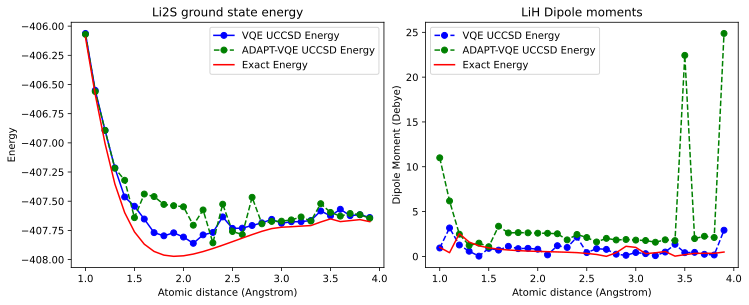

In [150]:

for dist in distances:
    #Qubit_Op
    qubit_op, num_particles, num_spin_orbitals, converter, problem = get_qubit_op(dist,mapper)
    #Initial State
    init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    #classic solver
    result_exact = exact_solver(problem, converter = converter)
    exact_energies.append(result_exact.total_energies)
    exact_dipole.append(np.linalg.norm(result_exact.dipole_moment_in_debye))
    #ansatz
    ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
    
    #VQE
  

    counts = []
    values = []
    params = []
    deviation = []
    dists.append(dist)
    
    # Set initial parameters of the ansatz
    initial_point = [0.01] * ansatz.num_parameters
    
    #VQE Solver
    vqe_factory=VQEUCCFactory(quantum_instance=qi
                         ,optimizer=optimizer
                         ,initial_point=initial_point
                         ,ansatz=ansatz
                         ,callback=callback
                        )
    
    #Normal VQE UCCSD
    solver_vqe=GroundStateEigensolver(converter,vqe_factory)

    vqe_calc=solver_vqe.solve(problem)
    vqe_energies.append(vqe_calc.total_energies)
    vqe_dipole.append(np.linalg.norm(vqe_calc.dipole_moment_in_debye))
    
    #ADAPT VQE
    solver_avqe = AdaptVQE(converter,vqe_factory,max_iterations=20)

    avqe_calc=solver_avqe.solve(problem)
    avqe_energies.append(avqe_calc.total_energies)
    avqe_dipole.append(np.linalg.norm(avqe_calc.dipole_moment_in_debye))
    
    #clear_output(wait=True)

    
fig, ax=plt.subplots(1,2,figsize=(10,4))
fig.tight_layout()

ax[0].plot(dists, vqe_energies, '-bo',label="VQE UCCSD Energy")
ax[0].plot(dists, avqe_energies, '--go',label="ADAPT-VQE UCCSD Energy")
ax[0].plot(dists, exact_energies,'r' ,label="Exact Energy")
ax[0].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy',title='Li2S ground state energy')
ax[0].legend()

ax[1].plot(dists, vqe_dipole, '--bo',label="VQE UCCSD Energy")
ax[1].plot(dists, avqe_dipole, '--go',label="ADAPT-VQE UCCSD Energy")
ax[1].plot(dists, exact_dipole,'r' ,label="Exact Energy")
ax[1].set(xlabel='Atomic distance (Angstrom)',ylabel='Dipole Moment (Debye)',title="LiH Dipole moments")
ax[1].legend()


plt.show()

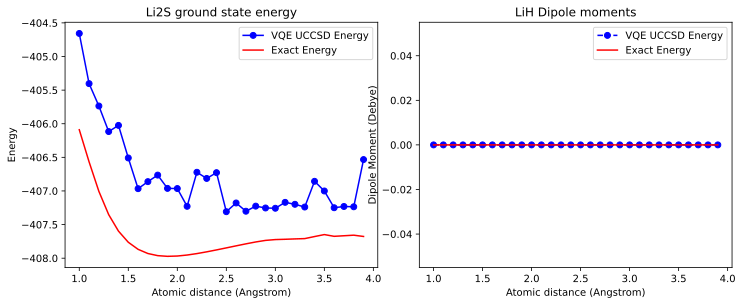

In [129]:
fig, ax=plt.subplots(1,2,figsize=(10,4))
fig.tight_layout()

ax[0].plot(dists, vqe_energies, '-bo',label="VQE UCCSD Energy")
#ax[0].plot(dists, avqe_energies, '--go',label="ADAPT-VQE UCCSD Energy")
ax[0].plot(dists, exact_energies,'r' ,label="Exact Energy")
ax[0].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy',title='Li2S ground state energy')
ax[0].legend()

ax[1].plot(dists, vqe_dipole, '--bo',label="VQE UCCSD Energy")
#ax[1].plot(dists, avqe_dipole, '--go',label="ADAPT-VQE UCCSD Energy")
ax[1].plot(dists, exact_dipole,'r' ,label="Exact Energy")
ax[1].set(xlabel='Atomic distance (Angstrom)',ylabel='Dipole Moment (Debye)',title="LiH Dipole moments")
ax[1].legend()


plt.show()

          
q_0: ─────
          
q_1: ─────
     ┌───┐
q_2: ┤ X ├
     └───┘
q_3: ─────
          


In [151]:
print(problem.interpret(result_exact))

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -421.317823091736
  - computed part:      -0.40220421273
  - ActiveSpaceTransformer extracted energy part: -335.169757080318
  - FreezeCoreTransformer extracted energy part: -85.745861798688
~ Nuclear repulsion energy (Hartree): 13.642592099775
> Total ground state energy (Hartree): -407.675230991961
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 1.000 S^2: 2.000 M: 0.392
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  6.20540626  0.0]
 
  0: 
  * Electronic dipole moment (a.u.): [0.00000114  6.39624886  0.0]
    - computed part:      [0.00000064  2.13045062  0.0]
    - ActiveSpaceTransformer extracted energy part: [0.0  0.00006429  0.0]
    - FreezeCoreTransformer extracted energy part: [0.00000049  4.26573395  0.0]
  > Dipole moment (a.u.): [-0.00000114  -0.1908426  0.0]  Total: 0.1908426
                 (debye): [-0.00000289  -0.48507345  0.0]  Total: 0.48507345
 


In [39]:
#Define Molecule
molecule = Molecule(
     # coordinates in Angstrom
    geometry=[
         ["Li", [1.0*np.sin(1.43), 1.0*np.cos(1.43), 0.0]],
         ["S", [0.0 ,0.0,0.0]],
         ["Li", [-1.0*np.sin(1.43), 1.0*np.cos(1.43), 0.0]]
     ],
     multiplicity=1,  # = 2*spin + 1
     charge=0,
)
    
#Set driver
driver = ElectronicStructureMoleculeDriver(
    molecule=molecule,
    basis="sto3g",
    driver_type=ElectronicStructureDriverType.PYSCF,
    )

    #Get properties
properties = driver.run()
    
#particle_number = problem.grouped_property_transformed.get_property("ParticleNumber")
num_a_electrons = properties.get_property("ParticleNumber").num_alpha
num_b_electrons = properties.get_property("ParticleNumber").num_beta
num_particles=properties.get_property("ParticleNumber").num_particles

num_spin_orbitals =int(properties.get_property("ParticleNumber").num_spin_orbitals)
#num_spin_orbitals= num_spin_orbitals.item()
#type(np.float64(0).item())

rep_energy = properties.get_property("ElectronicEnergy").nuclear_repulsion_energy
en_shift=0
#en_shift=properties.get_property("ElectronicEnergy").energy_shift
shift=rep_energy+en_shift
    
# Check the occupation of the spin orbitals
PN_property = properties.get_property("ParticleNumber")

# Define the active space
# (selected automatically around the HOMO and LUMO, ordered by energy)
transformer = ActiveSpaceTransformer(
    num_electrons=(8,8), #Electrons in active space
    num_molecular_orbitals=9 #Orbitals in active space
    #,active_orbitals=np.arange(1,11,1)
)
    
#Define the problem

problem = ElectronicStructureProblem(driver
                                          , [
                                            transformer 
                                            ,
                                            FreezeCoreTransformer(freeze_core=True
                                                                # ,remove_orbitals=[3,4,5]
                                                                 )
                                            ]
                                    )
    
second_q_ops = problem.second_q_ops() # Get 2nd Quant OP. This calls driver.run() internally
    
num_spin_orbitals = problem.num_spin_orbitals
num_particles = problem.num_particles
    
hamiltonian = second_q_ops[0] #Set Hamiltonian

    #Get Pauli OP
#converter = QubitConverter(mapper)
#qubit_op = converter.convert(hamiltonian)
    
    #Symmetries
#sym=Z2Symmetries.find_Z2_symmetries(qubit_op)
converter = QubitConverter(mapper
                               ,two_qubit_reduction=True
                              #,z2symmetry_reduction='auto'
                               #,z2symmetry_reduction=problem.symmetry_sector_locator(sym,converter)
                              )
    
    #Final OP
qubit_op = converter.convert(hamiltonian,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)

In [40]:
qubit_op.num_qubits

2

In [29]:
ansatz = EfficientSU2(num_qubits=qubit_op.num_qubits,su2_gates='ry', entanglement='linear', reps=3, initial_state=init_state)
ansatz.num_qubits

6

In [22]:
print(PN_property)

ParticleNumber:
	38 SOs
	11 alpha electrons
		orbital occupation: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
	11 beta electrons
		orbital occupation: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


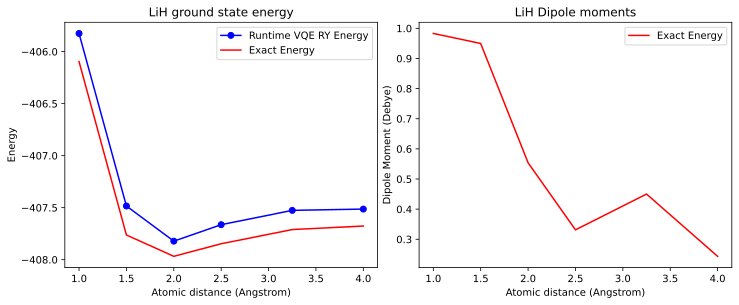

In [38]:
from qiskit_nature.runtime import VQEClient

distances = np.array([1.0,1.5,2.0,2.5,3.25,4.0])
exact_energies = []
rt_energies = []
exact_dipole=[]
rt_dipole=[]
optimizer = SPSA(maxiter=150)
mapper=ParityMapper()
measurement_error_mitigation = True
store_intermediate=True
    
def rt_callback(nfev, parameters, energy, stddev):
    display("Energy: {}, Std: {}".format(energy, stddev))
    clear_output(wait=True)
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)
    
dists=[]
intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

for dist in distances:
    #Qubit_Op
    qubit_op, num_particles, num_spin_orbitals, converter, problem = get_qubit_op(dist,mapper)
    #Initial State
    init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    #classic solver
    result_exact = exact_solver(problem, converter = converter)
    exact_energies.append(result_exact.total_energies)
    exact_dipole.append(np.linalg.norm(result_exact.dipole_moment_in_debye))
    #ansatz
    ansatz = EfficientSU2(num_qubits=qubit_op.num_qubits,su2_gates='ry', entanglement='linear', reps=3, initial_state=init_state)
    #initial point
    initial_point = [0.01] * ansatz.num_parameters
    
    
    #VQE
    runtime_vqe = VQEClient(ansatz=ansatz,
                         optimizer=optimizer,
                         initial_point=initial_point,
                         provider=provider,
                         backend=backend_nair,
                         shots=sh,
                         measurement_error_mitigation=measurement_error_mitigation,
                         callback=rt_callback,
                         store_intermediate=store_intermediate)

    rt_result = runtime_vqe.compute_minimum_eigenvalue(qubit_op)
    rt_energies.append(problem.interpret(rt_result).total_energies)
    rt_dipole.append(problem.interpret(rt_result).dipole_moment_in_debye)

    
fig, ax=plt.subplots(1,2,figsize=(10,4))
fig.tight_layout()

ax[0].plot(distances, rt_energies, '-bo',label="Runtime VQE RY Energy")
ax[0].plot(distances, exact_energies,'r' ,label="Exact Energy")
ax[0].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy',title='LiS2 ground state energy')
ax[0].legend()

ax[1].plot(distances, rt_dipole, '--bo',label="Runtime VQE RY Dipole")
ax[1].plot(distances, exact_dipole,'r' ,label="Exact Energy")
ax[1].set(xlabel='Atomic distance (Angstrom)',ylabel='Dipole Moment (Debye)',title="LiS2 Dipole moments")
ax[1].legend()


plt.show()

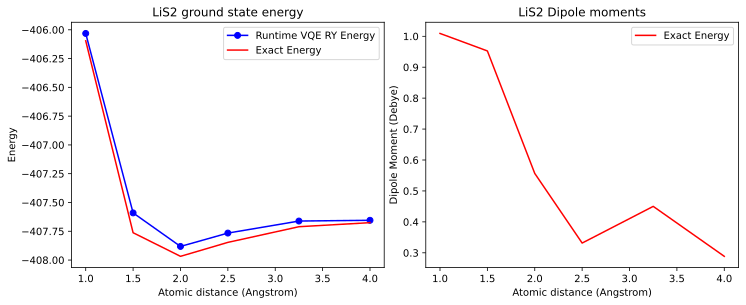

In [8]:
fig, ax=plt.subplots(1,2,figsize=(10,4))
fig.tight_layout()

ax[0].plot(distances, rt_energies, '-bo',label="Runtime VQE RY Energy")
ax[0].plot(distances, exact_energies,'r' ,label="Exact Energy")
ax[0].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy',title='LiS2 ground state energy')
ax[0].legend()

ax[1].plot(distances, rt_dipole, '--bo',label="Runtime VQE RY Dipole")
ax[1].plot(distances, exact_dipole,'r' ,label="Exact Energy")
ax[1].set(xlabel='Atomic distance (Angstrom)',ylabel='Dipole Moment (Debye)',title="LiS2 Dipole moments")
ax[1].legend()


plt.show()

In [9]:
qubit_op.num_qubits

4

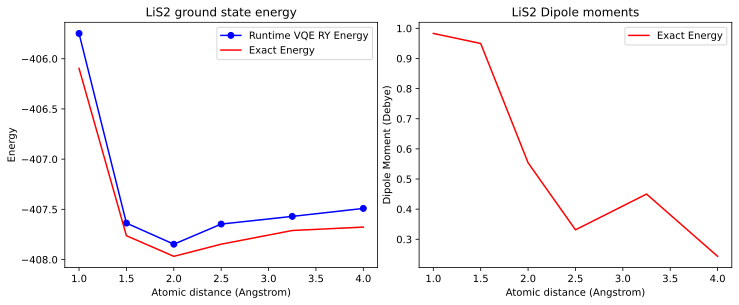

In [44]:
from qiskit_nature.runtime import VQEClient

distances = np.array([1.0,1.5,2.0,2.5,3.25,4.0])
exact_energies = []
rt_energies = []
exact_dipole=[]
rt_dipole=[]
optimizer = SPSA(maxiter=150)
mapper=ParityMapper()
measurement_error_mitigation = True
store_intermediate=True
    
def rt_callback(nfev, parameters, energy, stddev):
    display("Energy: {}, Std: {}".format(energy, stddev))
    clear_output(wait=True)
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)
    
dists=[]
intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

for dist in distances:
    #Qubit_Op
    qubit_op, num_particles, num_spin_orbitals, converter, problem = get_qubit_op(dist,mapper)
    #Initial State
    init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    #classic solver
    result_exact = exact_solver(problem, converter = converter)
    exact_energies.append(result_exact.total_energies)
    exact_dipole.append(np.linalg.norm(result_exact.dipole_moment_in_debye))
    #ansatz
    ansatz = EfficientSU2(num_qubits=qubit_op.num_qubits,su2_gates='ry', entanglement='linear', reps=3, initial_state=init_state)
    #initial point
    initial_point = [0.01] * ansatz.num_parameters
    
    
    #VQE
    runtime_vqe = VQEClient(ansatz=ansatz,
                         optimizer=optimizer,
                         initial_point=initial_point,
                         provider=provider,
                         backend=backend_nair,
                         shots=sh,
                         measurement_error_mitigation=measurement_error_mitigation,
                         callback=rt_callback,
                         store_intermediate=store_intermediate)

    rt_result = runtime_vqe.compute_minimum_eigenvalue(qubit_op)
    rt_energies.append(problem.interpret(rt_result).total_energies)
    rt_dipole.append(problem.interpret(rt_result).dipole_moment_in_debye)

    
fig, ax=plt.subplots(1,2,figsize=(10,4))
fig.tight_layout()

ax[0].plot(distances, rt_energies, '-bo',label="Runtime VQE RY Energy")
ax[0].plot(distances, exact_energies,'r' ,label="Exact Energy")
ax[0].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy',title='LiS2 ground state energy')
ax[0].legend()

ax[1].plot(distances, rt_dipole, '--bo',label="Runtime VQE RY Dipole")
ax[1].plot(distances, exact_dipole,'r' ,label="Exact Energy")
ax[1].set(xlabel='Atomic distance (Angstrom)',ylabel='Dipole Moment (Debye)',title="LiS2 Dipole moments")
ax[1].legend()


plt.show()

In [46]:
distances = np.array([1.0,1.5,2.0,2.5,3.25,4.0])

exact_rt_energies=[]
exact_rt_dipole=[]
for dist in distances:
    #Qubit_Op
    qubit_op, num_particles, num_spin_orbitals, converter, problem = get_qubit_op(dist,mapper)
    #Initial State
    #init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    #classic solver
    result_exact = exact_solver(problem, converter = converter)
    exact_rt_energies.append(result_exact.total_energies)
    exact_rt_dipole.append(np.linalg.norm(result_exact.dipole_moment_in_debye))

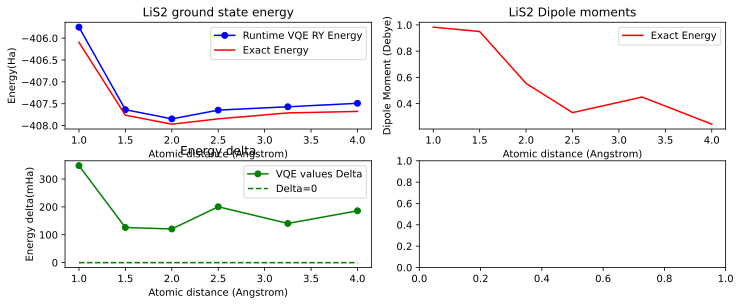

In [54]:

distances = np.array([1.0,1.5,2.0,2.5,3.25,4.0])
fig, ax=plt.subplots(2,2,figsize=(10,4))
fig.tight_layout()

ax[0][0].plot(distances, rt_energies, '-bo',label="Runtime VQE RY Energy")
ax[0][0].plot(distances, exact_rt_energies,'r' ,label="Exact Energy")
ax[0][0].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='LiS2 ground state energy')
ax[0][0].legend()

ax[0][1].plot(distances, rt_dipole, '--bo',label="Runtime VQE RY Energy")
ax[0][1].plot(distances, exact_rt_dipole,'r' ,label="Exact Energy")
ax[0][1].set(xlabel='Atomic distance (Angstrom)',ylabel='Dipole Moment (Debye)',title="LiS2 Dipole moments")
ax[0][1].legend()

ax[1][0].plot(distances, np.subtract(rt_energies,exact_rt_energies)*10**3, '-go',label="VQE values Delta")
ax[1][0].plot(distances, [0]*len(distances), '--g',label="Delta=0")
ax[1][0].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy delta(mHa)',title='Energy delta')
ax[1][0].legend()


plt.show()

In [33]:
#Runtime VQE

#Make qubit_operator

def get_qubit_op(dist,mapper):
    
    
    #Define Molecule
    molecule = Molecule(
        # coordinates in Angstrom
        geometry=[
            ["Li", [0.0, 0.0, 0.0]],
            ["H", [dist, 0.0, 0.0]]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )
    
    #Set driver
    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF,
    )
    
    driver_RKS = ElectronicStructureMoleculeDriver(
                                            molecule=molecule,
                                            basis="sto3g",
                                            driver_type=ElectronicStructureDriverType.PYSCF,
                                            method=MethodType.RKS

                                            )

    #Get properties
    properties = driver.run()
    
    # Check the occupation of the spin orbitals
    PN_property = properties.get_property("ParticleNumber")

    # Define the active space
    # (selected automatically around the HOMO and LUMO, ordered by energy)
    transformer = ActiveSpaceTransformer(
        num_electrons=2, #Electrons in active space
        num_molecular_orbitals=3, #Orbitals in active space
    )
    
    #Define the problem

    problem = ElectronicStructureProblem(driver
                                         , [
                                          #  transformer 
                                           # ,
                                             FreezeCoreTransformer(freeze_core=True
                                                                    ,remove_orbitals=[3,4]
                                                                       )
                                           ]
                                        )
    problem_RKS= ElectronicStructureProblem(driver_RKS
                                         , [
                                          #  transformer 
                                           # ,
                                             FreezeCoreTransformer(freeze_core=True
                                                                    ,remove_orbitals=[3,4]
                                                                        )
                                           ]
                                        )
    
    second_q_ops = problem_RKS.second_q_ops() # Get 2nd Quant OP. This calls driver.run() internally
    
    num_spin_orbitals = problem_RKS.num_spin_orbitals
    num_particles = problem_RKS.num_particles
    
    hamiltonian = second_q_ops[0] #Set Hamiltonian

    converter = QubitConverter(mapper
                               ,two_qubit_reduction=True
                               ,z2symmetry_reduction='auto'
                              )
    
    #Final OP
    qubit_op = converter.convert(hamiltonian,num_particles=num_particles,sector_locator=problem_RKS.symmetry_sector_locator)
    
    
    return qubit_op, num_particles, num_spin_orbitals, converter, problem, problem_RKS



In [34]:
dist=1.5
qubit_op, num_particles, num_spin_orbitals, converter, problem, problem_RKS = get_qubit_op(dist,mapper)
qubit_op.num_qubits

4

TypeError: 'AxesSubplot' object is not subscriptable

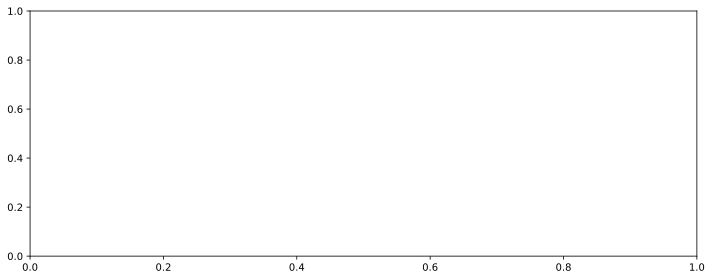

In [36]:


distances = np.arange(0.5, 4, 0.1)
RHF_energies = []
vqe_energies = []
KS_energies=[]
#exact_dipole=[]
#vqe_dipole=[]
#avqe_dipole=[]
optimizer = SLSQP(maxiter=10)
mapper=ParityMapper()


seed = 62
algorithm_globals.random_seed = seed
qi=backend_stv
#qi= QuantumInstance(backend_aer, seed_simulator=seed, seed_transpiler=seed, #Noisy Quantum Instance
 #                         coupling_map=coupling_map,noise_model=noise_model,
 #                        measurement_error_mitigation_cls=CompleteMeasFitter)

def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)
    
dists=[]
for dist in distances:
    #Qubit_Op
    qubit_op, num_particles, num_spin_orbitals, converter, problem, problem_RKS = get_qubit_op(dist,mapper)
    #Initial State
    init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    #classic solver RHF
    result_exact = exact_solver(problem, converter = converter)
    RHF_energies.append(result_exact.total_energies)
    #classic solver KS
    result_exact = exact_solver(problem_RKS, converter = converter)
    KS_energies.append(result_exact.total_energies)
    #exact_dipole.append(np.linalg.norm(result_exact.dipole_moment_in_debye))
    #ansatz
    ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
    
    #VQE
  

    counts = []
    values = []
    params = []
    deviation = []
    dists.append(dist)
    
    # Set initial parameters of the ansatz
    initial_point = [0.01] * ansatz.num_parameters
    
    #VQE Solver
    vqe_factory=VQEUCCFactory(quantum_instance=qi
                         ,optimizer=optimizer
                         ,initial_point=initial_point
                         ,ansatz=ansatz
                         ,callback=callback
                        )
    
    #Normal VQE UCCSD
    solver_vqe=GroundStateEigensolver(converter,vqe_factory)

    vqe_calc=solver_vqe.solve(problem_RKS)
    vqe_energies.append(vqe_calc.total_energies)
    #vqe_dipole.append(np.linalg.norm(vqe_calc.dipole_moment_in_debye))
    
    #ADAPT VQE
    #solver_avqe = AdaptVQE(converter,vqe_factory,max_iterations=20)

    #avqe_calc=solver_avqe.solve(problem)
   #avqe_energies.append(avqe_calc.total_energies)
    #avqe_dipole.append(np.linalg.norm(avqe_calc.dipole_moment_in_debye))
    
    #clear_output(wait=True)

    
fig, ax=plt.subplots(1,1,figsize=(10,4))
fig.tight_layout()

ax[0].plot(dists, vqe_energies, '-bo',label="VQE UCCSD Energy")
#ax[0].plot(dists, avqe_energies, '--go',label="ADAPT-VQE UCCSD Energy")
ax[0].plot(dists, RHF_energies,'r' ,label="RHF Energy")
ax[0].plot(dists, KS_energies,'r' ,label="KS Energy")
ax[0].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy',title='LiH ground state energy')
ax[0].legend()


#ax[1].plot(dists, vqe_dipole, '--bo',label="VQE UCCSD Energy")
#ax[1].plot(dists, avqe_dipole, '--go',label="ADAPT-VQE UCCSD Energy")
#ax[1].plot(dists, exact_dipole,'r' ,label="Exact Energy")
#ax[1].set(xlabel='Atomic distance (Angstrom)',ylabel='Dipole Moment (Debye)',title="LiH Dipole moments")
#ax[1].legend()


plt.show()

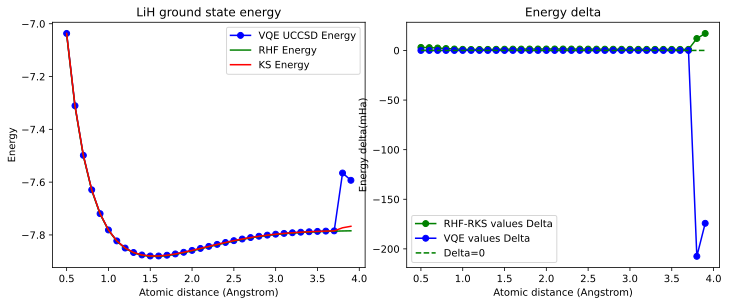

In [44]:
fig, ax=plt.subplots(1,2,figsize=(10,4))
fig.tight_layout()

ax[0].plot(dists, vqe_energies, '-bo',label="VQE UCCSD Energy")
#ax[0].plot(dists, avqe_energies, '--go',label="ADAPT-VQE UCCSD Energy")
ax[0].plot(dists, RHF_energies,'g' ,label="RHF Energy")
ax[0].plot(dists, KS_energies,'r' ,label="KS Energy")
ax[0].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy',title='LiH ground state energy')
ax[0].legend()

ax[1].plot(distances, np.subtract(KS_energies,RHF_energies)*10**3, '-go',label="RHF-RKS values Delta")
ax[1].plot(distances, np.subtract(KS_energies,vqe_energies)*10**3, '-bo',label="VQE values Delta")
ax[1].plot(distances, [0]*len(distances), '--g',label="Delta=0")
ax[1].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy delta(mHa)',title='Energy delta')
ax[1].legend()